# 1. Configuración

1. Imports Centralizados

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torchaudio
import soundfile as sf

import re

from tqdm import tqdm
import transformers
from transformers import AutoModel

/opt/anaconda3/envs/mert310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Se comprueba el entorno Python

In [2]:
sys.executable, sys.version

('/opt/anaconda3/envs/mert310/bin/python',
 '3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]')

3. Se comprueban las versiones de las librerías

In [3]:
print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("transformers:", transformers.__version__)
print("soundfile:", sf.__version__)

torch: 2.9.1
torchaudio: 2.9.1
transformers: 4.37.2
soundfile: 0.13.1


4. Paths de lectura de dataset y de escritura de resultados

In [4]:
DATA_ROOT = Path("../EGFxSet")
OUT_DIR   = Path("./outputs_01_mert_base_egfxset")

OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists(), "->", DATA_ROOT)
print("OUT_DIR exists:", OUT_DIR.exists(), "->", OUT_DIR)

DATA_ROOT exists: True -> ../EGFxSet
OUT_DIR exists: True -> outputs_01_mert_base_egfxset


5. Dispositivo

In [5]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

'mps'

6. Información del dispositivo

In [6]:
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))
elif device == "mps":
    print("Apple Silicon MPS enabled")
else:
    print("CPU only")

Apple Silicon MPS enabled


7. Funciones para sacar la velocidad de inferencia y otras métricas

In [7]:
import time
import numpy as np
import torch

def _sync():
    if device == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize()
    elif device == "mps" and hasattr(torch, "mps"):
        try:
            torch.mps.synchronize()
        except Exception:
            pass

def _summ(times_s, label=""):
    times = np.array(times_s, dtype=np.float64)
    return {
        "label": label,
        "n": int(times.size),
        "mean_ms": float(times.mean() * 1000),
        "p50_ms": float(np.percentile(times, 50) * 1000),
        "p95_ms": float(np.percentile(times, 95) * 1000),
        "min_ms": float(times.min() * 1000),
        "max_ms": float(times.max() * 1000),
        "runs_per_s": float(1.0 / times.mean()),
    }

# 2. Preparación del Dataset EGFxSet

1. Se recorren todos los WAV y se comprueba cuántos hay

In [8]:
wav_paths = sorted(DATA_ROOT.rglob("*.wav"))
print("Total: ", len(wav_paths))

Total:  8970


2. Se crean las funciones para recuperar el nombre del tono y la pastilla utilizada

In [9]:
def tone_name(p: Path) -> str:
    # DATA_ROOT/<TONE>/<PICKUP>/<file.wav>
    return p.relative_to(DATA_ROOT).parts[0]

def pickup_name(p: Path) -> str:
    # DATA_ROOT/<TONE>/<PICKUP>/<file.wav>
    return p.relative_to(DATA_ROOT).parts[1]

# sanity check
example = wav_paths[0]
print("Ejemplo:", example)
print("Tono:", tone_name(example))
print("Pastilla:", pickup_name(example))
print("Nombre del fichero:", example.name)

Ejemplo: ../EGFxSet/BluesDriver/Bridge/1-0.wav
Tono: BluesDriver
Pastilla: Bridge
Nombre del fichero: 1-0.wav


3. Se construye el DataFrame con metadatos básicos

In [10]:
PAT = re.compile(r"(?P<string>\d+)-(?P<fret>\d+)\.wav$", re.IGNORECASE)

rows = []
for p in tqdm(wav_paths):
    rel = p.relative_to(DATA_ROOT)
    parts = rel.parts

    # Esperado: (tone, pickup, filename)
    if len(parts) < 3:
        continue

    m = PAT.search(p.name)
    if not m:
        continue

    rows.append({
        "path": str(p),
        "tone": parts[0],
        "pickup": parts[1],
        "string": int(m.group("string")),
        "fret": int(m.group("fret")),
    })

df = pd.DataFrame(rows)
df.head(), df.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8970/8970 [00:00<00:00, 400738.22it/s]


(                                     path         tone  pickup  string  fret
 0   ../EGFxSet/BluesDriver/Bridge/1-0.wav  BluesDriver  Bridge       1     0
 1   ../EGFxSet/BluesDriver/Bridge/1-1.wav  BluesDriver  Bridge       1     1
 2  ../EGFxSet/BluesDriver/Bridge/1-10.wav  BluesDriver  Bridge       1    10
 3  ../EGFxSet/BluesDriver/Bridge/1-11.wav  BluesDriver  Bridge       1    11
 4  ../EGFxSet/BluesDriver/Bridge/1-12.wav  BluesDriver  Bridge       1    12,
 (8947, 5))

4. Checkeo de datos

In [11]:
print("tones:", df["tone"].nunique(), sorted(df["tone"].unique())[:15])
print("pickups:", df["pickup"].nunique(), sorted(df["pickup"].unique())[:15])
print("strings:", sorted(df["string"].unique()))
print("fret range:", df["fret"].min(), df["fret"].max())

df.groupby(["tone","pickup"]).size().sort_values(ascending=False).head(20)

tones: 13 ['BluesDriver', 'Chorus', 'Clean', 'Digital Delay', 'Flanger', 'Hall Reverb', 'Phaser', 'Plate Reverb', 'RAT', 'Spring Reverb', 'Sweep Echo', 'TapeEcho', 'TubeScreamer']
pickups: 5 ['Bridge', 'Bridge-Middle', 'Middle', 'Middle-Neck', 'Neck']
strings: [1, 2, 3, 4, 5, 6]
fret range: 0 45


tone           pickup       
BluesDriver    Bridge           138
Phaser         Middle-Neck      138
Plate Reverb   Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
RAT            Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
Spring Reverb  Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
Sweep Echo     Bridge           138
               Bridge-Middle    138
               Middle           138
dtype: int64

5. Clase tone_pickup: la combinación tono + pastilla utilizada es lo que queremos diferenciar

In [12]:
df["tone_pickup"] = df["tone"].astype(str) + "__" + df["pickup"].astype(str)

print("tone_pickup classes:", df["tone_pickup"].nunique())
df["tone_pickup"].value_counts().head(20)

tone_pickup classes: 65


tone_pickup
BluesDriver__Bridge             138
Phaser__Middle-Neck             138
Plate Reverb__Bridge            138
Plate Reverb__Bridge-Middle     138
Plate Reverb__Middle            138
Plate Reverb__Middle-Neck       138
Plate Reverb__Neck              138
RAT__Bridge                     138
RAT__Bridge-Middle              138
RAT__Middle                     138
RAT__Middle-Neck                138
RAT__Neck                       138
Spring Reverb__Bridge           138
Spring Reverb__Bridge-Middle    138
Spring Reverb__Middle           138
Spring Reverb__Middle-Neck      138
Spring Reverb__Neck             138
Sweep Echo__Bridge              138
Sweep Echo__Bridge-Middle       138
Sweep Echo__Middle              138
Name: count, dtype: int64

In [13]:
counts = df["tone_pickup"].value_counts()

print("min examples per class:", counts.min())
print("classes with <2 examples:", (counts < 2).sum())

df_eval = df[df["tone_pickup"].isin(counts[counts >= 2].index)].copy()
print("df_eval shape:", df_eval.shape)

min examples per class: 115
classes with <2 examples: 0
df_eval shape: (8947, 6)


6. Se calcula el pitch. Está afinada en E estándar, por lo que en base a la cuerda y al traste se puede extraer el valor exacto

In [14]:
# Afinación estándar en MIDI por cuerda
# (clave = nº de cuerda tal como viene en el nombre del wav)
OPEN_STRING_MIDI = {
    6: 40,  # E2
    5: 45,  # A2
    4: 50,  # D3
    3: 55,  # G3
    2: 59,  # B3
    1: 64,  # E4
}

def compute_midi_pitch(row):
    return OPEN_STRING_MIDI[row["string"]] + row["fret"]

df["midi_pitch"] = df.apply(compute_midi_pitch, axis=1)

df[["string", "fret", "midi_pitch"]].head(10)

,string,fret,midi_pitch
0,1,0,64
1,1,1,65
2,1,10,74
3,1,11,75
4,1,12,76
5,1,13,77
6,1,14,78
7,1,15,79
8,1,16,80
9,1,17,81


7. Se guardan los metadatos en un .csv

In [15]:
INDEX_COLS = [
    "path",
    "tone",
    "pickup",
    "tone_pickup",
    "string",
    "fret",
    "midi_pitch",
]

index_path = OUT_DIR / "egfxset_index.csv"

df[INDEX_COLS].to_csv(index_path, index=False)

print("Index guardado en:", index_path)
print("Columnas:", INDEX_COLS)
print("Filas:", len(df))

Index guardado en: outputs_01_mert_base_egfxset/egfxset_index.csv
Columnas: ['path', 'tone', 'pickup', 'tone_pickup', 'string', 'fret', 'midi_pitch']
Filas: 8947


# 3. MERT Baseline

1. Se carga MERT

In [16]:
MERT_MODEL_NAME = "m-a-p/MERT-v1-330M"

print("Loading MERT model:", MERT_MODEL_NAME)

mert_model = AutoModel.from_pretrained(
    MERT_MODEL_NAME,
    trust_remote_code=True
)

mert_model.to(device)
mert_model.eval()

print("MERT loaded on device:", device)

Loading MERT model: m-a-p/MERT-v1-330M


Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MERT loaded on device: mps


2. Activación de output_hidden_states + definición de la extracción “layerwise stats”

In [17]:
from transformers import AutoProcessor
import torch.nn.functional as F

# Processor (prepara el audio para MERT)
processor = AutoProcessor.from_pretrained(MERT_MODEL_NAME, trust_remote_code=True)

# Pedimos hidden_states (todas las capas) en la salida
mert_model.config.output_hidden_states = True

# Config audio (igual que antes)
MAX_SECONDS = 5.0
TARGET_SR = 24000

def load_audio(path: str | Path):
    """Carga wav -> mono -> resample a 24k -> recorta a 5s"""
    wav, sr = sf.read(str(path))
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = torch.from_numpy(wav).float()
    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR
    wav = wav[: int(sr * MAX_SECONDS)]
    return wav, sr

def temporal_stats_pool(x: torch.Tensor) -> torch.Tensor:
    """
    Stats pooling temporal: concat(mean, std)
    x: (T, D) -> (2D,)
    """
    mu = x.mean(dim=0)
    sigma = x.std(dim=0, unbiased=False)
    return torch.cat([mu, sigma], dim=0)

def extract_layerwise_stats(path: str | Path) -> torch.Tensor:
    """
    UNA pasada por WAV:
      - obtiene hidden_states (todas las capas)
      - aplica stats pooling temporal por capa (mean+std)
    Devuelve tensor (L, 2D) en CPU.
    """
    x, sr = load_audio(path)
    inputs = processor(x.numpy(), sampling_rate=sr, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        out = mert_model(**inputs)

    hs = out.hidden_states
    if hs is None:
        raise RuntimeError("hidden_states es None. Revisa output_hidden_states=True.")

    layer_vecs = []
    for h in hs:
        h = h.squeeze(0)                # (T, D)
        v = temporal_stats_pool(h)      # (2D,)
        v = F.normalize(v, dim=0)       # normaliza por capa
        layer_vecs.append(v)

    return torch.stack(layer_vecs, dim=0).detach().cpu()  # (L, 2D)

H = extract_layerwise_stats(df["path"].iloc[0])
print("layerwise stats shape:", H.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


layerwise stats shape: torch.Size([25, 2048])


2. Benchmark

In [18]:
paths_bench = df["path"].tolist()

n_warmup = 10
n_runs = 50

for p in paths_bench[:n_warmup]:
    _ = extract_layerwise_stats(p)

times = []
for p in paths_bench[:n_runs]:
    _sync()
    t0 = time.perf_counter()
    _ = extract_layerwise_stats(p)
    _sync()
    t1 = time.perf_counter()
    times.append(t1 - t0)

stats_mert_e2e = _summ(times, label="MERT E2E (load+processor+forward+pool)")
stats_mert_e2e

{'label': 'MERT E2E (load+processor+forward+pool)',
 'n': 50,
 'mean_ms': 49.0366649000498,
 'p50_ms': 48.94504200001393,
 'p95_ms': 50.088109900252675,
 'min_ms': 47.3152080003274,
 'max_ms': 53.893999999672815,
 'runs_per_s': 20.39290400434603}

3. Benchmark forward-only

In [19]:
p0 = df["path"].iloc[0]
x, sr = load_audio(p0)
inputs = processor(x.numpy(), sampling_rate=sr, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

mert_model.eval()

n_warmup = 30
n_runs = 200

with torch.inference_mode():

    for _ in range(n_warmup):
        _ = mert_model(**inputs)
    _sync()

    times = []
    for _ in range(n_runs):
        _sync()
        t0 = time.perf_counter()
        _ = mert_model(**inputs)
        _sync()
        t1 = time.perf_counter()
        times.append(t1 - t0)

stats_mert_forward = _summ(times, label="MERT FORWARD ONLY (model(**inputs))")
stats_mert_forward

{'label': 'MERT FORWARD ONLY (model(**inputs))',
 'n': 200,
 'mean_ms': 44.19515163003325,
 'p50_ms': 44.002167000599,
 'p95_ms': 45.31565835040965,
 'min_ms': 43.04966699965007,
 'max_ms': 46.99845799950708,
 'runs_per_s': 22.62691637243847}

3. Extraer y guardar el cache layerwise para TODOS los WAVs

In [20]:
import numpy as np

paths = df["path"].tolist()
N = len(paths)

H0 = extract_layerwise_stats(paths[0])
L, D2 = H0.shape

print("N wavs:", N)
print("Layerwise shape per wav:", (L, D2))

out_path = OUT_DIR / "mert_layerwise_stats_fp16.npy"

mm = np.memmap(out_path, dtype=np.float16, mode="w+", shape=(N, L, D2))

mm[0] = H0.numpy().astype(np.float16)

for i, p in enumerate(tqdm(paths[1:], desc="Caching layerwise stats"), start=1):
    Hi = extract_layerwise_stats(p)  # (L, 2D) en CPU
    mm[i] = Hi.numpy().astype(np.float16)

mm.flush()
print("Saved cache to:", out_path)

N wavs: 8947
Layerwise shape per wav: (25, 2048)


Caching layerwise stats: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8946/8946 [09:21<00:00, 15.93it/s]


Saved cache to: outputs_01_mert_base_egfxset/mert_layerwise_stats_fp16.npy


4. A partir del cache multicapa, se crean muchas versiones de embeddings finales (por vista de capas y por pooling de capas) para poder comparar cuál separa mejor tone_pickup sin recomputar MERT.

In [21]:
cache_path = OUT_DIR / "mert_layerwise_stats_fp16.npy"
N = len(df)
mm = np.memmap(cache_path, dtype=np.float16, mode="r", shape=(N, L, D2))

def layer_slices(L: int):
    a = L // 3
    b = 2 * L // 3
    return {
        "early": slice(0, a),
        "mid": slice(a, b),
        "late": slice(b, L),
        "all": slice(0, L),
        "early_mid": slice(0, b),
        "mid_late": slice(a, L),
    }

def pool_layers(X: np.ndarray, mode: str) -> np.ndarray:
    """
    X: (N, Lsel, D2)
    devuelve:
      - layer_mean:  (N, D2)
      - layer_max:   (N, D2)
      - layer_stats: (N, 2*D2)  concat(mean, std) sobre capas
    """
    X = X.astype(np.float32)
    if mode == "layer_mean":
        return X.mean(axis=1)
    elif mode == "layer_max":
        return X.max(axis=1)
    elif mode == "layer_stats":
        mu = X.mean(axis=1)
        sd = X.std(axis=1, ddof=0)
        return np.concatenate([mu, sd], axis=1)
    else:
        raise ValueError(f"Unknown mode: {mode}")

VIEW_SLICES = layer_slices(L)
LAYER_POOLINGS = ["layer_mean", "layer_max", "layer_stats"]

print("Views:", {k: (v.start, v.stop) for k, v in VIEW_SLICES.items()})
print("Poolings:", LAYER_POOLINGS)

for view_name, sl in VIEW_SLICES.items():
    X = mm[:, sl, :]  # (N, Lsel, D2)
    for pmode in LAYER_POOLINGS:
        E = pool_layers(X, pmode)
        out_path = OUT_DIR / f"embeddings_{view_name}__{pmode}.npy"
        np.save(out_path, E)
        print("Saved:", out_path.name, "shape:", E.shape)

Views: {'early': (0, 8), 'mid': (8, 16), 'late': (16, 25), 'all': (0, 25), 'early_mid': (0, 16), 'mid_late': (8, 25)}
Poolings: ['layer_mean', 'layer_max', 'layer_stats']
Saved: embeddings_early__layer_mean.npy shape: (8947, 2048)
Saved: embeddings_early__layer_max.npy shape: (8947, 2048)
Saved: embeddings_early__layer_stats.npy shape: (8947, 4096)
Saved: embeddings_mid__layer_mean.npy shape: (8947, 2048)
Saved: embeddings_mid__layer_max.npy shape: (8947, 2048)
Saved: embeddings_mid__layer_stats.npy shape: (8947, 4096)
Saved: embeddings_late__layer_mean.npy shape: (8947, 2048)
Saved: embeddings_late__layer_max.npy shape: (8947, 2048)
Saved: embeddings_late__layer_stats.npy shape: (8947, 4096)
Saved: embeddings_all__layer_mean.npy shape: (8947, 2048)
Saved: embeddings_all__layer_max.npy shape: (8947, 2048)
Saved: embeddings_all__layer_stats.npy shape: (8947, 4096)
Saved: embeddings_early_mid__layer_mean.npy shape: (8947, 2048)
Saved: embeddings_early_mid__layer_max.npy shape: (8947, 204

# 4. Evaluación

In [22]:
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = OUT_DIR / "figures_mert"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=300):
    """
    Guarda la figura en FIG_DIR con nombre 'name'. Se añade .png si no lo lleva.
    """
    name = name if name.lower().endswith(".png") else f"{name}.png"
    out = OUT_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved:", out)

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

labels = df["tone_pickup"].astype(str).to_numpy()
N = len(labels)

emb_files = sorted(OUT_DIR.glob("embeddings_*.npy"))
print("Found embedding files:", len(emb_files))

results = []

for f in emb_files:
    X = np.load(f).astype(np.float32)          # (N, D)
    X = l2_normalize(X)

    # Similaridad coseno = X @ X.T
    S = X @ X.T
    np.fill_diagonal(S, -np.inf)

    # Top-1
    nn1 = np.argmax(S, axis=1)
    top1 = (labels[nn1] == labels).mean()

    # Top-5
    nn5 = np.argpartition(-S, kth=5, axis=1)[:, :5]
    top5 = np.array([labels[i] in labels[nn5[r]] for r, i in enumerate(range(N))]).mean()

    results.append({
        "file": f.name,
        "dim": X.shape[1],
        "top1": float(top1),
        "top5": float(top5),
    })

res_df = pd.DataFrame(results).sort_values(["top1", "top5"], ascending=False)
res_df.head(20)

Found embedding files: 18


,file,dim,top1,top5
9,embeddings_late__layer_max.npy,2048,0.152565,0.495473
11,embeddings_late__layer_stats.npy,4096,0.151336,0.489214
10,embeddings_late__layer_mean.npy,2048,0.148877,0.483626
15,embeddings_mid_late__layer_max.npy,2048,0.139488,0.465296
17,embeddings_mid_late__layer_stats.npy,4096,0.136582,0.449760
16,embeddings_mid_late__layer_mean.npy,2048,0.135464,0.443165
0,embeddings_all__layer_max.npy,2048,0.133005,0.450766
12,embeddings_mid__layer_max.npy,2048,0.129205,0.444507
14,embeddings_mid__layer_stats.npy,4096,0.127976,0.440371
13,embeddings_mid__layer_mean.npy,2048,0.127529,0.435565


In [24]:
N_CLASSES = df["tone_pickup"].nunique()
chance = 1.0 / N_CLASSES

res_df_eval = res_df.copy()
res_df_eval["chance"] = chance
res_df_eval["top1_vs_chance"] = res_df_eval["top1"] / chance

res_df_eval = res_df_eval.sort_values(
    ["top1", "top5"], ascending=False
)

res_df_eval.head(10)

,file,dim,top1,top5,chance,top1_vs_chance
9,embeddings_late__layer_max.npy,2048,0.152565,0.495473,0.015385,9.916732
11,embeddings_late__layer_stats.npy,4096,0.151336,0.489214,0.015385,9.836817
10,embeddings_late__layer_mean.npy,2048,0.148877,0.483626,0.015385,9.676987
15,embeddings_mid_late__layer_max.npy,2048,0.139488,0.465296,0.015385,9.066726
17,embeddings_mid_late__layer_stats.npy,4096,0.136582,0.449760,0.015385,8.877836
16,embeddings_mid_late__layer_mean.npy,2048,0.135464,0.443165,0.015385,8.805186
0,embeddings_all__layer_max.npy,2048,0.133005,0.450766,0.015385,8.645356
12,embeddings_mid__layer_max.npy,2048,0.129205,0.444507,0.015385,8.398346
14,embeddings_mid__layer_stats.npy,4096,0.127976,0.440371,0.015385,8.318431
13,embeddings_mid__layer_mean.npy,2048,0.127529,0.435565,0.015385,8.289371


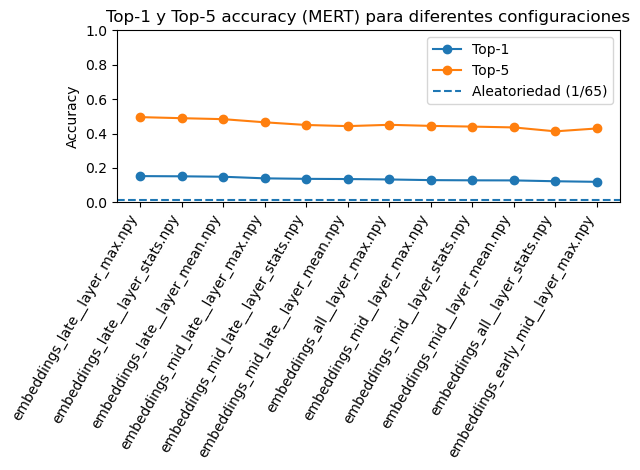

Saved: outputs_01_mert_base_egfxset/mert_top1_top5.png


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Top-N configuraciones a mostrar
TOPN = 12

plot_df = res_df_eval.sort_values(["top1", "top5"], ascending=False).head(TOPN).copy()

x = np.arange(len(plot_df))
labels = plot_df["file"].tolist()

plt.figure()
plt.plot(x, plot_df["top1"].to_numpy(), marker="o", label="Top-1")
plt.plot(x, plot_df["top5"].to_numpy(), marker="o", label="Top-5")

chance = float(plot_df["chance"].iloc[0])
plt.axhline(chance, linestyle="--", label=f"Aleatoriedad (1/{int(round(1/chance))})")

plt.xticks(x, labels, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.title(f"Top-1 y Top-5 accuracy (MERT) para diferentes configuraciones")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

savefig(plt.gcf(), "mert_top1_top5")
plt.close(plt.gcf())

Best embedding: embeddings_late__layer_max.npy


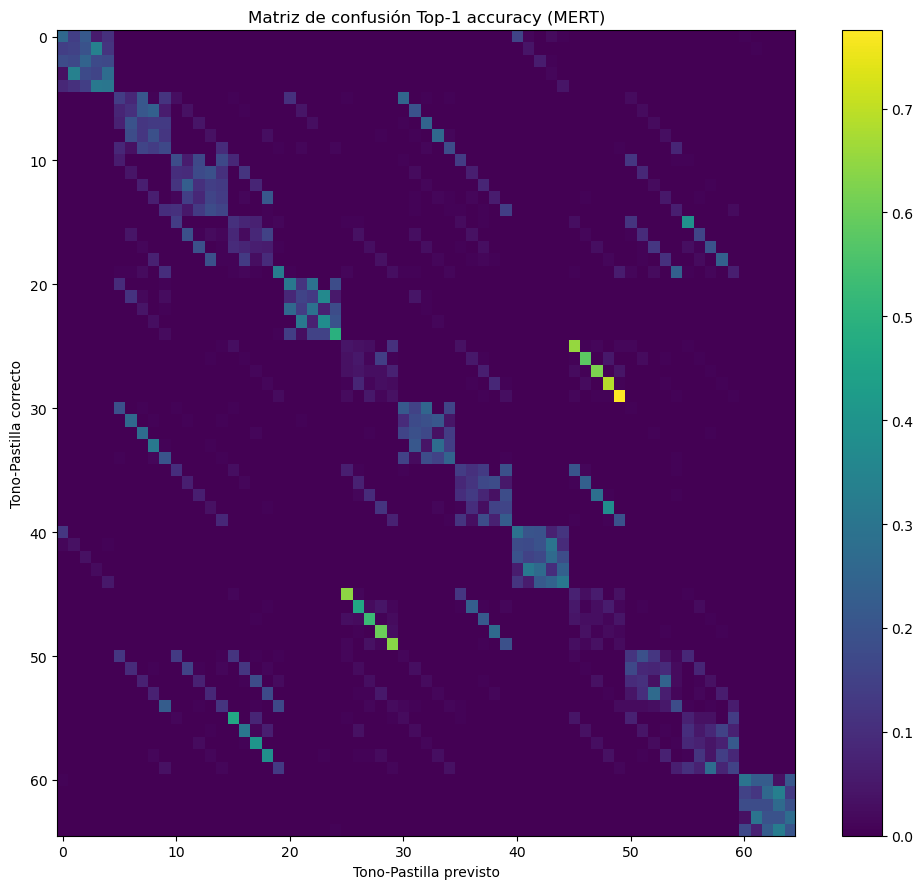

Saved: outputs_01_mert_base_egfxset/mert_confusion.png


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Elegimos el mejor fichero según Top-1
best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR / best_file
print("Best embedding:", best_file)

# Cargamos embeddings y labels
X = np.load(best_path).astype(np.float32)
labels = df["tone_pickup"].astype(str).to_numpy()
assert X.shape[0] == len(labels), f"Mismatch: X has {X.shape[0]} rows, labels has {len(labels)}"

# Normalizamos y calculamos vecino Top-1
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
S = X @ X.T
np.fill_diagonal(S, -np.inf)
nn1 = np.argmax(S, axis=1)

y_true = labels
y_pred = labels[nn1]

# Matriz de confusión (conteos) y normalización por fila
cm = pd.crosstab(y_true, y_pred)  # filas: true, columnas: pred
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)  # por fila

# Plot
plt.figure(figsize=(10, 9))
plt.imshow(cm_norm.to_numpy(), aspect="auto")
plt.title(f"Matriz de confusión Top-1 accuracy (MERT)")
plt.xlabel("Tono-Pastilla previsto")
plt.ylabel("Tono-Pastilla correcto")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_off = cm.copy()
for k in cm_off.index:
    if k in cm_off.columns:
        cm_off.loc[k, k] = 0

top_conf = (
    cm_off.stack()
    .sort_values(ascending=False)
    .head(20)
)
top_conf

savefig(plt.gcf(), "mert_confusion")
plt.close(plt.gcf())

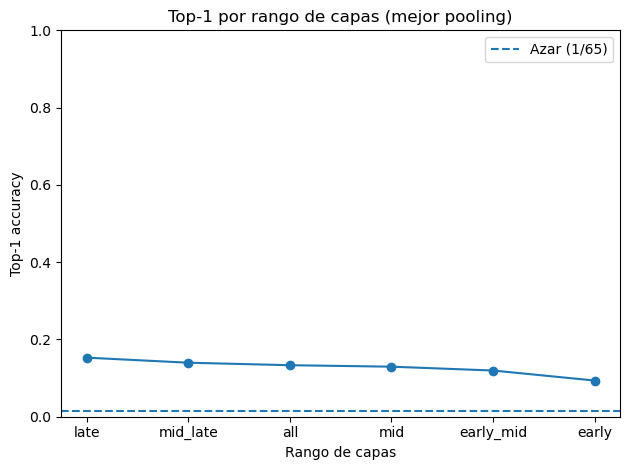

Saved: outputs_01_mert_base_egfxset/mert_top1_capas_pooling.png


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_plot = res_df_eval.copy()

def get_layer_group(fname):
    if "__" in fname:
        return fname.split("__")[0].replace("embeddings_", "")
    return fname

df_plot["layer_group"] = df_plot["file"].apply(get_layer_group)

# Para cada grupo de capas, cogemos el MEJOR Top-1
agg = (
    df_plot
    .groupby("layer_group")["top1"]
    .max()
    .sort_values(ascending=False)
)

plt.figure()
plt.plot(agg.index, agg.values, marker="o")
plt.axhline(df_plot["chance"].iloc[0], linestyle="--", label="Azar (1/65)")
plt.ylabel("Top-1 accuracy")
plt.xlabel("Rango de capas")
plt.title("Top-1 por rango de capas (mejor pooling)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

savefig(plt.gcf(), "mert_top1_capas_pooling")
plt.close(plt.gcf())

Best embedding: embeddings_late__layer_max.npy
Top-1 tone_pickup: 0.1525651056219962 chance: 0.015384615384615385
Top-1 tone only   : 0.6035542639991058 chance: 0.07692307692307693


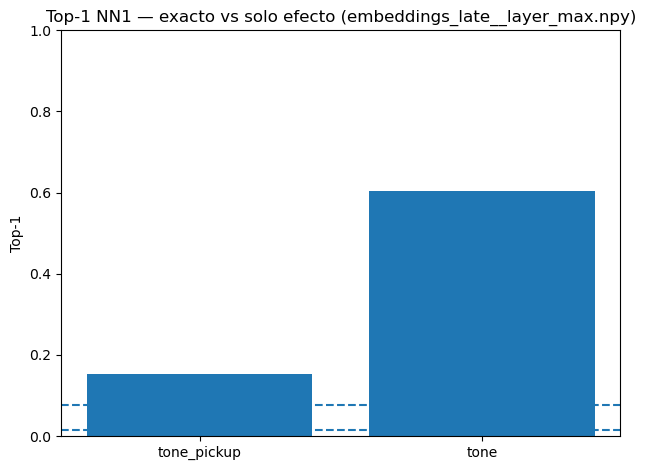

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR / best_file
print("Best embedding:", best_file)

X = np.load(best_path).astype(np.float32)
labels_tp = df["tone_pickup"].astype(str).to_numpy()
labels_tone = df["tone"].astype(str).to_numpy()

assert X.shape[0] == len(labels_tp)

X = l2_normalize(X)
S = X @ X.T
np.fill_diagonal(S, -np.inf)
nn1 = np.argmax(S, axis=1)

top1_tone_pickup = float((labels_tp[nn1] == labels_tp).mean())

top1_tone = float((labels_tone[nn1] == labels_tone).mean())

chance_tone_pickup = 1.0 / df["tone_pickup"].nunique()
chance_tone = 1.0 / df["tone"].nunique()

print("Top-1 tone_pickup:", top1_tone_pickup, "chance:", chance_tone_pickup)
print("Top-1 tone only   :", top1_tone, "chance:", chance_tone)

plt.figure()
plt.bar(["tone_pickup", "tone"], [top1_tone_pickup, top1_tone])
plt.axhline(chance_tone_pickup, linestyle="--")
plt.axhline(chance_tone, linestyle="--")
plt.ylabel("Top-1")
plt.title(f"Top-1 NN1 — exacto vs solo efecto ({best_file})")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [29]:
tabla = res_df_eval.copy()

tabla["Configuración"] = tabla["file"]
tabla["Capas usadas"] = tabla["file"].apply(lambda x: x.split("__")[0].replace("embeddings_", ""))
tabla["Pooling de capas"] = tabla["file"].apply(lambda x: x.split("__")[1].replace(".npy", ""))
tabla["Dimensión"] = tabla["dim"]
tabla["Top-1"] = tabla["top1"].round(3)
tabla["Top-5"] = tabla["top5"].round(3)
tabla["Veces mejor que azar"] = tabla["top1_vs_chance"].round(1)

tabla_final = tabla[
    ["Configuración", "Capas usadas", "Pooling de capas", 
     "Dimensión", "Top-1", "Top-5", "Veces mejor que azar"]
].sort_values("Top-1", ascending=False)

tabla_final.head(100)

,Configuración,Capas usadas,Pooling de capas,Dimensión,Top-1,Top-5,Veces mejor que azar
9,embeddings_late__layer_max.npy,late,layer_max,2048,0.153,0.495,9.9
11,embeddings_late__layer_stats.npy,late,layer_stats,4096,0.151,0.489,9.8
10,embeddings_late__layer_mean.npy,late,layer_mean,2048,0.149,0.484,9.7
15,embeddings_mid_late__layer_max.npy,mid_late,layer_max,2048,0.139,0.465,9.1
17,embeddings_mid_late__layer_stats.npy,mid_late,layer_stats,4096,0.137,0.450,8.9
16,embeddings_mid_late__layer_mean.npy,mid_late,layer_mean,2048,0.135,0.443,8.8
0,embeddings_all__layer_max.npy,all,layer_max,2048,0.133,0.451,8.6
12,embeddings_mid__layer_max.npy,mid,layer_max,2048,0.129,0.445,8.4
13,embeddings_mid__layer_mean.npy,mid,layer_mean,2048,0.128,0.436,8.3
14,embeddings_mid__layer_stats.npy,mid,layer_stats,4096,0.128,0.440,8.3


t-SNE

Usando best_file: embeddings_late__layer_max.npy | top1=0.1526 | top5=0.4955


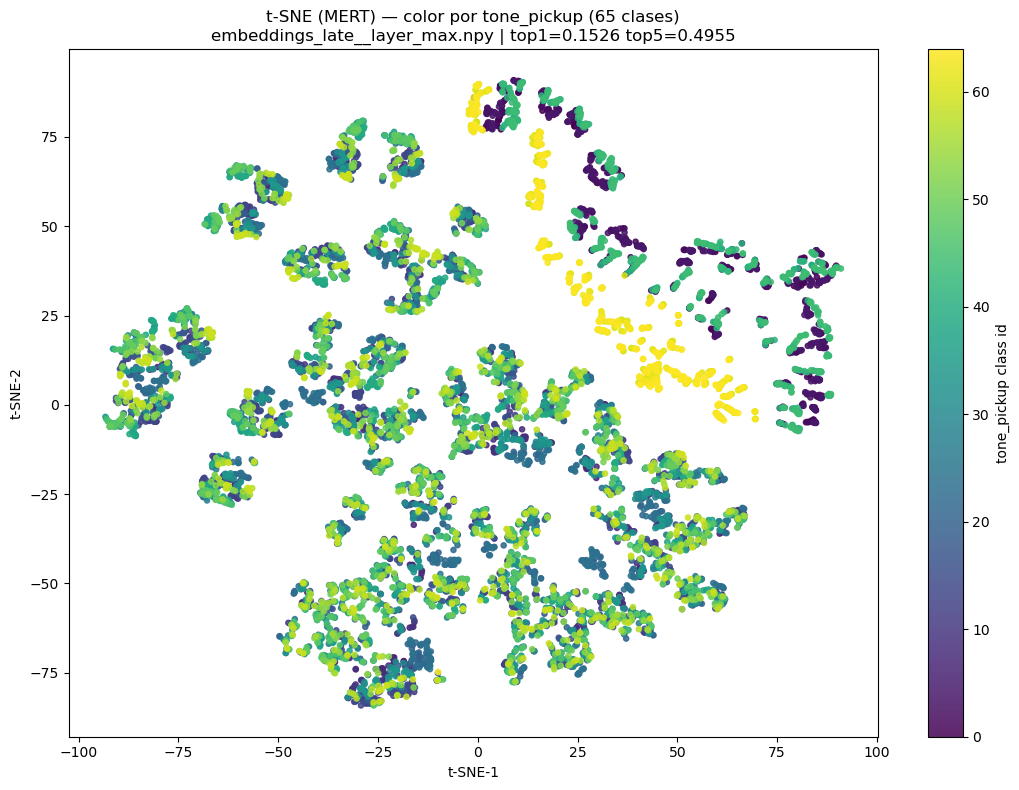

Saved: outputs_01_mert_base_egfxset/mert_tsne_global_tone_pickup_embeddings_late__layer_max.png


In [30]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

best_row = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]
best_file = best_row["file"]
best_top1 = best_row["top1"]
best_top5 = best_row["top5"]

best_path = OUT_DIR / best_file
print(f"Usando best_file: {best_file} | top1={best_top1:.4f} | top5={best_top5:.4f}")

X = np.load(best_path).astype(np.float32)   # (N, D)
assert X.shape[0] == len(df), f"X filas ({X.shape[0]}) != df filas ({len(df)})"

labels = df["tone_pickup"].astype(str).to_numpy()

X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

pca_dim = min(50, X.shape[1])
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

N = X_pca.shape[0]
perplexity = max(5, min(30, (N - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
Z = tsne.fit_transform(X_pca)

uniq = sorted(set(labels.tolist()))
lab2i = {u:i for i,u in enumerate(uniq)}
c = np.array([lab2i[x] for x in labels], dtype=int)

plt.figure(figsize=(11, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=c, s=14, alpha=0.85)
plt.title(f"t-SNE (MERT) — color por tone_pickup (65 clases)\n{best_file} | top1={best_top1:.4f} top5={best_top5:.4f}")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
cb = plt.colorbar()
cb.set_label("tone_pickup class id")
plt.tight_layout()
plt.show()

savefig(plt.gcf(), f"mert_tsne_global_tone_pickup_{Path(best_file).stem}")
plt.close(plt.gcf())

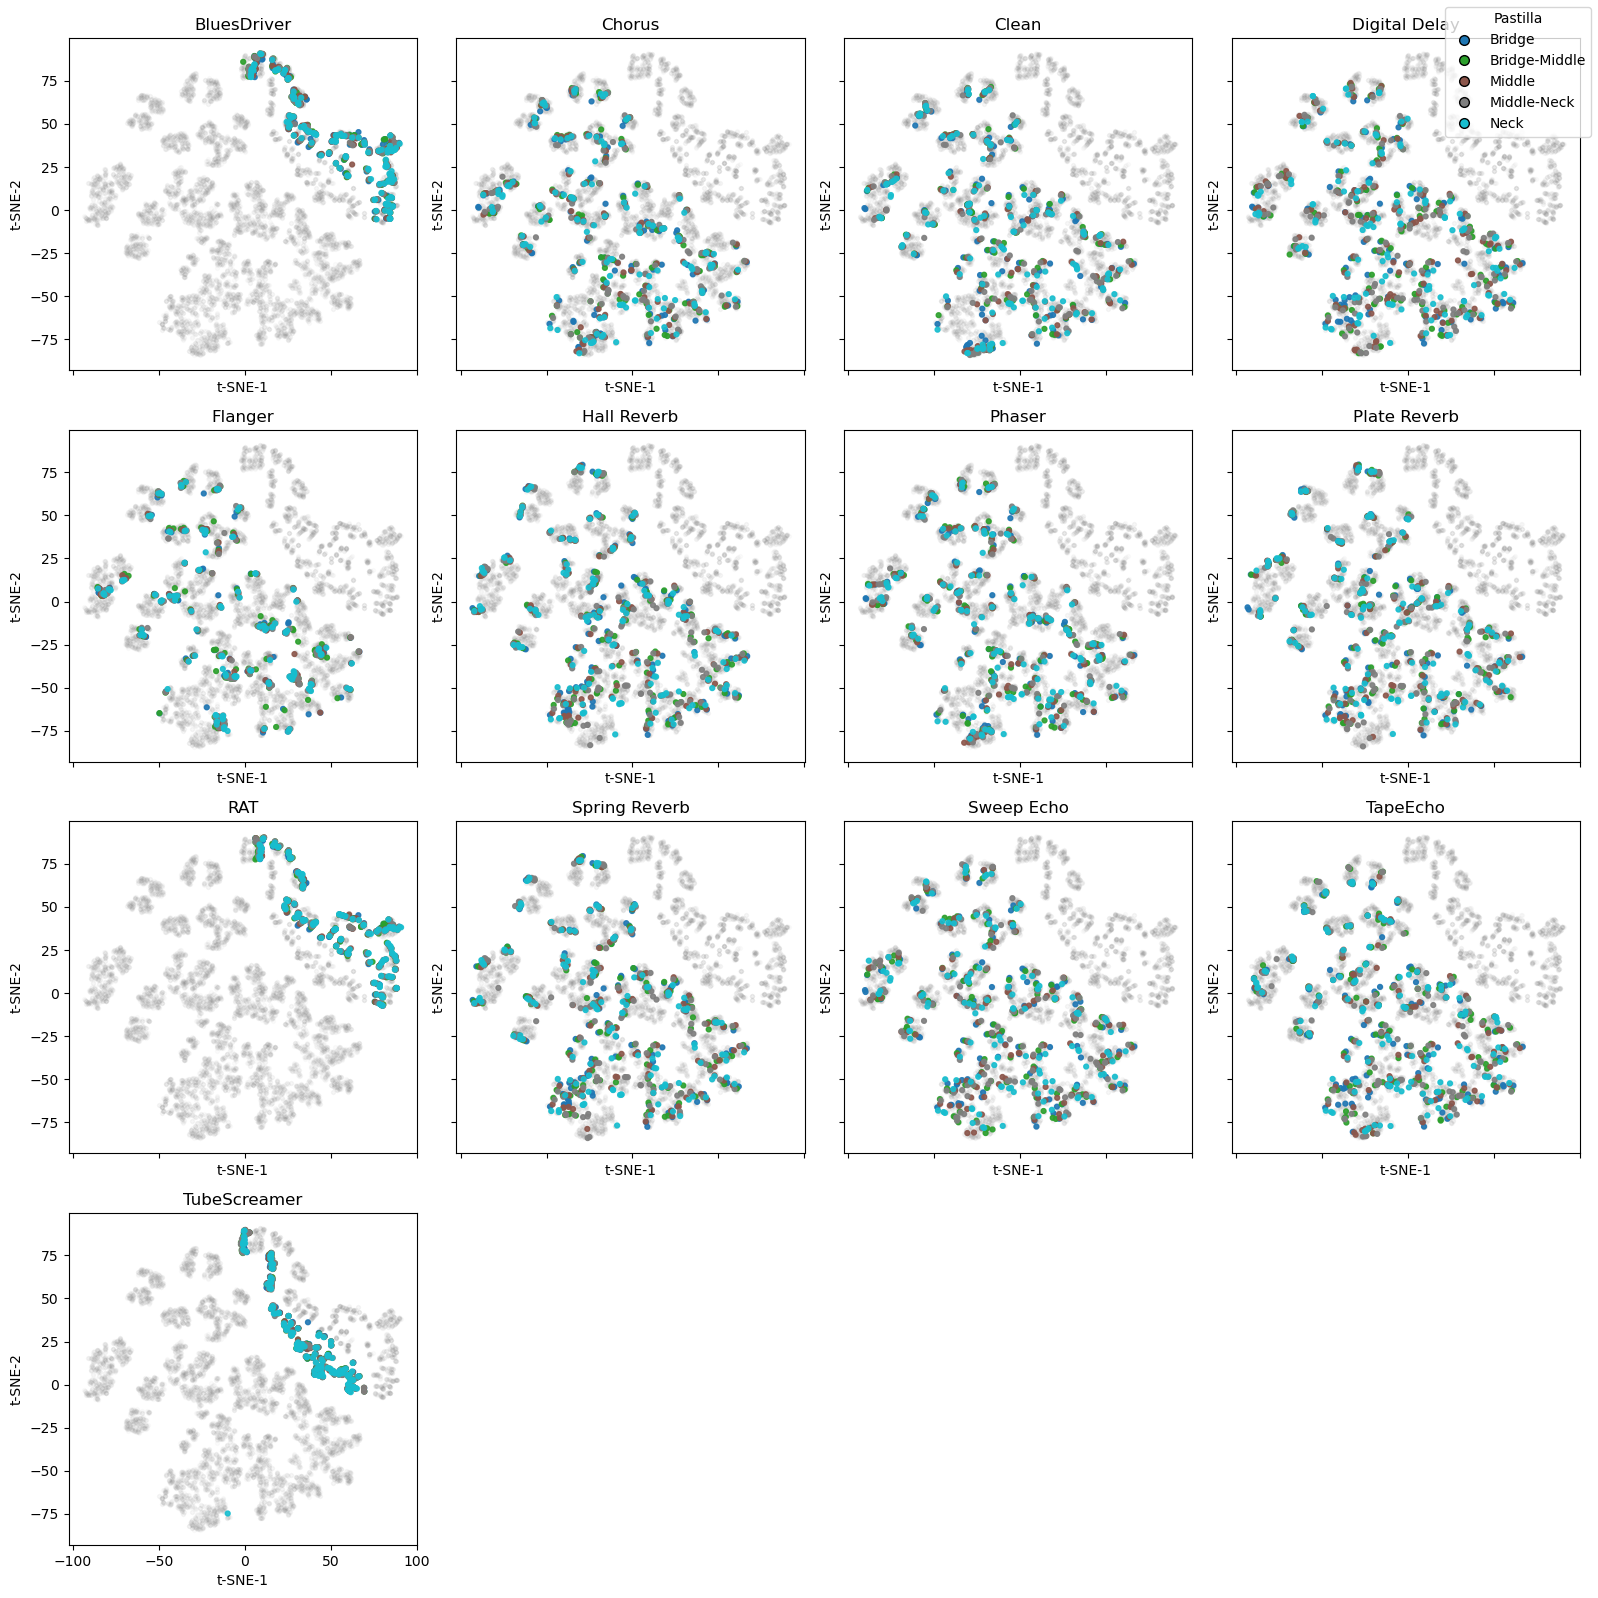

Saved: outputs_01_mert_base_egfxset/mert_tsne_subplots_by_tone_color_pickup_embeddings_late__layer_max.png


In [33]:
import numpy as np
import matplotlib.pyplot as plt

tones = sorted(df["tone"].astype(str).unique())
pickups = sorted(df["pickup"].astype(str).unique())

p2i = {p:i for i,p in enumerate(pickups)}
pickup_ids = df["pickup"].astype(str).map(p2i).to_numpy()

cmap = plt.get_cmap("tab10", len(pickups))

n = len(tones)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, 4*nrows),
    sharex=True,
    sharey=True
)
axes = np.array(axes).reshape(-1)

for ax, t in zip(axes, tones):
    m = (df["tone"].astype(str).to_numpy() == t)

    ax.scatter(
        Z[~m, 0], Z[~m, 1],
        s=8, alpha=0.03, color="grey"
    )

    ax.scatter(
        Z[m, 0], Z[m, 1],
        c=pickup_ids[m],
        cmap=cmap,
        s=12,
        alpha=0.9,
        vmin=0,
        vmax=len(pickups)-1
    )

    ax.set_title(t)
    ax.set_xlabel("t-SNE-1")
    ax.set_ylabel("t-SNE-2")

for k in range(len(tones), len(axes)):
    axes[k].axis("off")

handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=7,
        markerfacecolor=cmap(i),
        markeredgecolor='black',
        label=p
    )
    for p, i in p2i.items()
]

fig.legend(
    handles=handles,
    title="Pastilla",
    loc="upper right"
)

plt.tight_layout()
plt.show()

savefig(fig, f"mert_tsne_subplots_by_tone_color_pickup_{Path(best_file).stem}")
plt.close(fig)

In [32]:
import pandas as pd

rows = []

for d in [stats_mert_e2e, stats_mert_forward]:
    rows.append({
        "model": "MERT",
        "variant": d.get("label", ""),
        "device": device,
        "n_runs": d.get("n", None),
        "mean_ms": d.get("mean_ms", None),
        "p50_ms": d.get("p50_ms", None),
        "p95_ms": d.get("p95_ms", None),
        "min_ms": d.get("min_ms", None),
        "max_ms": d.get("max_ms", None),
        "runs_per_s": d.get("runs_per_s", None),
    })

infer_mert_df = pd.DataFrame(rows).sort_values(["model", "variant"])
infer_mert_df

,model,variant,device,n_runs,mean_ms,p50_ms,p95_ms,min_ms,max_ms,runs_per_s
0,MERT,MERT E2E (load+processor+forward+pool),mps,50,49.036665,48.945042,50.088110,47.315208,53.894000,20.392904
1,MERT,MERT FORWARD ONLY (model(**inputs)),mps,200,44.195152,44.002167,45.315658,43.049667,46.998458,22.626916
